In [1]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from dataset.galaxy_dataset import *
from utils import schemas
from utils.utils import *
from models.utils import *
import pandas as pd
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
root = "/data/public/renhaoye/mgs/"
subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
for subdir in subdirs:
    sys.path.append(subdir)
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)

In [2]:
def get_metric(true_label, pred_label):
    return len(true_label), accuracy_score(true_label, pred_label), precision_score(true_label, pred_label, average='weighted'), recall_score(true_label, pred_label, average='weighted'), f1_score(true_label, pred_label, average='weighted')
def check_dependency(data, question, threshold, name):
    depend = question.asked_after
    if depend is None:
        return data
    else:
        other_q = question.asked_after.question.answers
        other_q = [answer.text for answer in other_q if answer.text != depend.text]
        if name == "_fraction":
            check = data[depend.text + "_fraction"] > threshold
        else:
            check = pd.Series([True] * len(data), index=data.index)
        for q in other_q:
            column_name = depend.text + name
            other_column_name = q + name
            if column_name in data.columns and other_column_name in data.columns:
                check &= (data[column_name] > data[other_column_name])
        return check_dependency(data[check], depend.question, threshold, name)
def performance(data, total_votes=0, threshold=0):
    metrics = pd.DataFrame(columns=['Question', 'Count', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for question in schema.questions:
        label_df, fraction_df, mean_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        for answer in question.answers:
            label_col, frac_col, mean_col = f"{answer.text}_label", f"{answer.text}_fraction", f"{answer.text}_meanf"
            if label_col in data.columns and frac_col in data.columns and mean_col in data.columns:
                check_depend_data = check_dependency(data, question, threshold, name="_fraction")
                check_depend_predict = check_dependency(data, question, threshold, name="_meanf")
                label_df[answer.text], fraction_df[answer.text], mean_df[answer.text] = check_depend_data[label_col], check_depend_data[frac_col], check_depend_predict[mean_col]
        votes_sum = label_df.sum(axis=1)
        idx_max = fraction_df[votes_sum > total_votes].idxmax(axis=1) # 对大于一定投票数的数据，找到最大的fraction
        frac_mask = (fraction_df.apply(lambda row: row[idx_max[row.name]] if row.name in idx_max else 0, axis=1) > threshold) == True
        true_label = idx_max[frac_mask].apply(lambda x: x.replace('_fraction', ''))
        pred_label = mean_df.idxmax(axis=1).apply(lambda x: x.replace('_meanf', ''))
        # pred_label = pred_label[pred_label.index.isin(true_label.index)]
        missing_indices = true_label.index.difference(pred_label.index)
        for idx in missing_indices:
            pred_label.at[idx] = 'wrong_prediction'  # 使用一个特定的标记来表示错误预测

        # 确保 true_label 和 pred_label 的索引一致
        common_indices = true_label.index.intersection(pred_label.index)
        true_label = true_label[common_indices]
        pred_label = pred_label[common_indices]
        count, accuracy, precision, recall, f1 = get_metric(true_label, pred_label)
        new_row = pd.DataFrame({'Question': [question.text], 'Count': [count], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})
        metrics = pd.concat([metrics, new_row])
    return metrics
def arcsinh_rgb(imgs, bands, scales=None,m = 0.03):
    import numpy as np
    rgbscales =dict(g=(2,6.0), r=(1,3.4), z=(0,2.2))
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)

    Q = 50
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    # fI = MTF(I)
    I += (I == 0.) * 1e-9
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I
    rgb = np.clip(rgb, 0, 1)
    return rgb

In [125]:
performance(pd.read_csv("/data/public/renhaoye/mgs/ye_2024_uda_f_nouda.csv"), total_votes=34, threshold=0.8)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,319,0.943574,0.949922,0.943574,0.943744
0,disk_edge_on,117,0.965812,1.000000,0.965812,0.982595
0,has_spiral_arms,95,0.968421,1.000000,0.968421,0.983957
0,bar,20,0.950000,1.000000,0.950000,0.974286
0,bulge_size,7,1.000000,1.000000,1.000000,1.000000
0,how_rounded,25,1.000000,1.000000,1.000000,1.000000
0,edge_on_bulge,1,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,14,0.928571,1.000000,0.928571,0.962857
0,spiral_arm_count,22,0.954545,0.911157,0.954545,0.932347
0,merging,87,1.000000,1.000000,1.000000,1.000000


In [123]:
performance(pd.read_csv("/data/public/renhaoye/mgs/overlap_south_source_model.csv"), total_votes=34, threshold=0.5)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,835,0.935329,0.931947,0.935329,0.933581
0,disk_edge_on,128,0.992188,0.992898,0.992188,0.992357
0,has_spiral_arms,103,0.990291,0.980677,0.990291,0.985461
0,bar,86,0.837209,0.858383,0.837209,0.845381
0,bulge_size,85,0.894118,0.874689,0.894118,0.883672
0,how_rounded,41,0.902439,0.926829,0.902439,0.913249
0,edge_on_bulge,5,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,60,0.816667,0.815260,0.816667,0.813777
0,spiral_arm_count,46,0.847826,0.836353,0.847826,0.837959
0,merging,190,0.978947,0.979670,0.978947,0.979128


In [124]:
performance(pd.read_csv("/data/public/renhaoye/mgs/ye_2024_uda_i_18.csv"), total_votes=34, threshold=0.8)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,319,0.968652,0.970714,0.968652,0.968730
0,disk_edge_on,117,0.991453,1.000000,0.991453,0.995707
0,has_spiral_arms,95,1.000000,1.000000,1.000000,1.000000
0,bar,20,1.000000,1.000000,1.000000,1.000000
0,bulge_size,7,1.000000,1.000000,1.000000,1.000000
0,how_rounded,25,0.960000,0.963077,0.960000,0.960000
0,edge_on_bulge,1,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,14,1.000000,1.000000,1.000000,1.000000
0,spiral_arm_count,22,0.954545,0.911157,0.954545,0.932347
0,merging,87,0.988506,1.000000,0.988506,0.992337


In [37]:
performance(pd.read_csv("/data/public/renhaoye/mgs/valid54.csv"), total_votes=34, threshold=0.5)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,8162,0.952463,0.952678,0.952463,0.950599
0,disk_edge_on,1187,0.966302,0.993128,0.966302,0.979528
0,has_spiral_arms,924,0.939394,0.961933,0.939394,0.950343
0,bar,704,0.869318,0.906629,0.869318,0.885572
0,bulge_size,758,0.886544,0.906678,0.886544,0.895993
0,how_rounded,1222,0.926350,0.944609,0.926350,0.935043
0,edge_on_bulge,93,0.924731,0.949691,0.924731,0.936155
0,spiral_winding,537,0.843575,0.880573,0.843575,0.857697
0,spiral_arm_count,456,0.877193,0.889862,0.877193,0.879679
0,merging,4336,0.985701,0.986155,0.985701,0.985294


In [38]:
performance(pd.read_csv("/data/public/renhaoye/mgs/valid54.csv"), total_votes=34, threshold=0.8)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,2819,0.995388,0.992227,0.995388,0.993799
0,disk_edge_on,831,0.996390,0.998821,0.996390,0.997596
0,has_spiral_arms,633,0.996840,1.000000,0.996840,0.998418
0,bar,97,1.000000,1.000000,1.000000,1.000000
0,bulge_size,68,1.000000,1.000000,1.000000,1.000000
0,how_rounded,352,1.000000,1.000000,1.000000,1.000000
0,edge_on_bulge,28,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,66,0.984848,1.000000,0.984848,0.992356
0,spiral_arm_count,210,0.985714,0.990873,0.985714,0.988175
0,merging,2007,0.998505,0.999502,0.998505,0.998949


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv("/data/public/renhaoye/mgs/ye_2024_uda_i_27.csv")
def cfm(data, votes_th=20, threshold=0.5):
    metrics = pd.DataFrame(columns=['Question', 'Answer', 'Method', 'Count', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for question in schema.questions:
        for answer in question.answers:
            true_data = data[answer.text + '_fraction']
            predicted_data = data[answer.text + '_meanf']
            votes = data[answer.text + '_label']
            # Method 1
            mask1 = (true_data > threshold) & (votes > votes_th)
            true_labels1 = (true_data[mask1] > 0.5).astype(int)
            predicted_labels1 = (predicted_data[mask1] > 0.5).astype(int)
            count1 = mask1.sum()
            accuracy1 = accuracy_score(true_labels1, predicted_labels1)
            precision1 = precision_score(true_labels1, predicted_labels1, average='binary')
            recall1 = recall_score(true_labels1, predicted_labels1, average='binary')
            f11 = f1_score(true_labels1, predicted_labels1, average='binary')
            metrics = metrics.append({'Question': question.text, 'Answer': answer.text, 'Method': 'Method1', 'Count': count1, 'Accuracy': accuracy1, 'Precision': precision1, 'Recall': recall1, 'F1': f11}, ignore_index=True)
    return metrics
cfm(data, votes_th=20, threshold=0.5)

,Question,Answer,Method,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,smooth_or_featured_smooth,Method1,454,0.938326,1.0,0.938326,0.968182
1,smooth_or_featured,smooth_or_featured_featured_or_disk,Method1,357,0.731092,1.0,0.731092,0.844660
2,smooth_or_featured,smooth_or_featured_artifact,Method1,3,0.000000,0.0,0.000000,0.000000
3,disk_edge_on,disk_edge_on_yes,Method1,50,1.000000,1.0,1.000000,1.000000
4,disk_edge_on,disk_edge_on_no,Method1,276,0.996377,1.0,0.996377,0.998185
5,has_spiral_arms,has_spiral_arms_yes,Method1,209,0.952153,1.0,0.952153,0.975490
6,has_spiral_arms,has_spiral_arms_no,Method1,8,0.875000,1.0,0.875000,0.933333
7,bar,bar_strong,Method1,17,0.764706,1.0,0.764706,0.866667
8,bar,bar_weak,Method1,11,0.454545,1.0,0.454545,0.625000
9,bar,bar_no,Method1,98,0.846939,1.0,0.846939,0.917127


In [9]:
def error_df(data, total_votes=20, threshold=0):
    error_detail_dict = {}
    metrics = pd.DataFrame(columns=['Question', 'Method', 'Count', 'Accuracy', 'Precision', 'Recall', 'F1'])
    parent_dir = '/data/public/renhaoye/morphics/error_save/'
    mask_dict = {}
    ans_dict = {}
    for question in schema.questions:
        label_df = pd.DataFrame()
        fraction_df = pd.DataFrame()
        mean_df = pd.DataFrame()
        for answer in question.answers:
            answer_label_col = answer.text + '_label'
            answer_fraction_col = answer.text + '_fraction'
            answer_mean_col = answer.text + '_meanf'
            if answer_label_col in data.columns and answer_fraction_col in data.columns and answer_mean_col in data.columns:
                # Adding columns to the respective DataFrames
                label_df[answer.text] = data[answer_label_col]
                fraction_df[answer.text] = data[answer_fraction_col]
                mean_df[answer.text] = data[answer_mean_col]
        votes_sum = label_df.sum(axis=1)
        mask_votes = votes_sum > total_votes
        idx_max = fraction_df[mask_votes].idxmax(axis=1)
        mask_fraction = fraction_df.lookup(idx_max.index, idx_max.values) > threshold
        true_label = idx_max[mask_fraction].apply(lambda x: x.replace('_fraction', ''))
        # true_label = label_df[mask_votes].idxmax(axis=1).apply(lambda x: x.replace('_label', ''))
        pred_label = mean_df.idxmax(axis=1).apply(lambda x: x.replace('_meanf', ''))
        pred_label = pred_label[pred_label.index.isin(true_label.index)]
        count1 = len(true_label)
        accuracy1 = accuracy_score(true_label, pred_label)
        precision1 = precision_score(true_label, pred_label, average='weighted')
        recall1 = recall_score(true_label, pred_label, average='weighted')
        f11 = f1_score(true_label, pred_label, average='weighted')
        metrics = metrics.append({'Question': question.text, 'Method': 'Method1', 'Count': count1, 'Accuracy': accuracy1, 'Precision': precision1, 'Recall': recall1, 'F1': f11}, ignore_index=True)
        mask = true_label != pred_label
        error_details = {idx: (true_label[idx], pred_label[idx]) for idx in mask[mask].index}
        error_detail_dict[question.text] = error_details
        mask = mask.reindex(data.index, fill_value=False)
        answer_dir = os.path.join(parent_dir, question.text)
        os.makedirs(answer_dir, exist_ok=True)
        mask_dict[question.text] = mask
    mask_all = pd.concat(mask_dict.values(), axis=1).any(axis=1)
    error_data_all = data[mask_all]
    return mask_dict, error_data_all, error_detail_dict


In [19]:
data = pd.read_csv("/data/public/renhaoye/mgs/ye_2024_uda_i_27.csv")
mask_dict, error_data_all, error_detail_dict = error_df(data, total_votes=20, threshold=0.8)
error_details = error_detail_dict.items()
error_details

dict_items([('smooth_or_featured', {142: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 320: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 577: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 991: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 1603: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 1671: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 1721: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 2396: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 2532: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth'), 2555: ('smooth_or_featured_featured_or_disk', 'smooth_or_featured_smooth')}), ('disk_edge_on', {}), ('has_spiral_arms', {42: ('has_spiral_arms_no', 'has_spiral_arms_yes'), 391: ('has_spiral_arms_yes', 'has_spiral_arms_no'), 707: ('has_spiral_arms_no', 'has_spiral_arms_yes'), 713: ('h

In [20]:
def display_images_for_each_question(data, error_detail_dict, image_path_column='Image Path', keys=0):
    key = list(error_detail_dict.keys())
    for question, error_details in error_detail_dict.items():
        if question == key[keys]:
            entropy_column = f'{question}_entropy'
            if entropy_column in data.columns:
                sorted_error_details = sorted(error_details.items(), key=lambda x: data.loc[x[0], entropy_column])
            else:
                print(f"Column '{entropy_column}' not found in data. Skipping sorting.")
                sorted_error_details = error_details.items()
            num_errors = len(sorted_error_details)
            num_rows = np.ceil(num_errors / 10).astype(int)
            fig = plt.figure(figsize=(20, 2*num_rows), dpi=200)
            fig.suptitle(f"Errors for: {question}", fontsize=10)
            for idx, (sample_idx, (true_class, pred_class)) in enumerate(sorted_error_details):
                img_path = data.loc[sample_idx, image_path_column]
                pred = data.loc[sample_idx, f'{pred_class}_meanf']
                frac = data.loc[sample_idx, f'{true_class}_fraction']
                entropy = data.loc[sample_idx, f'{question}_entropy']
                if not os.path.exists(img_path):
                    print(f"Image not found at: {img_path}")
                    continue
                img = arcsinh_rgb(fits.getdata(img_path), ["g", "r", "z"])
                ax = fig.add_subplot(num_rows, 10, idx+1)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"True: {true_class.split('_')[-1]} {frac:.2f}\nPred: {pred_class.split('_')[-1]} {pred:.2f}\n {entropy:.2f}")

            plt.tight_layout()
            plt.show()
import random
def display_images_sorted_by_probability(data, error_detail_dict, image_path_column='Image Path', keys=0):
    key = list(error_detail_dict.keys())
    for question, error_details in error_detail_dict.items():
        if question == key[keys]:
            # 自动提取与问题相关的选项
            options = [col.replace(question + '_', '').replace('_meanf', '') 
                       for col in data.columns if col.startswith(question + '_') and col.endswith('_meanf')]
            # 随机选择一个问题选项
            random_option = random.choice(list(set([item[1] for item in error_details.values()])))
            probability_column = f'{random_option}_meanf'

            # 检查列名是否存在于 DataFrame 中
            if probability_column in data.columns:
                # 根据预测概率排序
                sorted_error_details = sorted(error_details.items(), key=lambda x: data.loc[x[0], probability_column], reverse=True)
                print(f"Sorting by column: '{probability_column}'")  # 打印用于排序的列名
            else:
                print(f"Column '{probability_column}' not found in data. Skipping sorting.")
                sorted_error_details = error_details.items()

            num_errors = len(sorted_error_details)
            num_rows = np.ceil(num_errors / 10).astype(int)
            fig = plt.figure(figsize=(20, 2*num_rows), dpi=200)
            fig.suptitle(f"Errors for: {question}, sorted by probability of '{random_option}'", fontsize=10)

            for idx, (sample_idx, (true_class, pred_class)) in enumerate(sorted_error_details):
                img_path = data.loc[sample_idx, image_path_column]
                if not os.path.exists(img_path):
                    print(f"Image not found at: {img_path}")
                    continue

                # 获取所有选项的预测概率
                probabilities = {opt: data.loc[sample_idx, f'{question}_{opt}_meanf'] for opt in options}
                entropy = data.loc[sample_idx, f'{question}_entropy']
                # 构造包含所有概率的标题
                probability_str = ' | '.join([f'{opt}: {prob:.2f}\n' for opt, prob in probabilities.items()])
                title = f"True: {true_class.split('_')[-1]} \n Pred: {pred_class.split('_')[-1]} \n  {entropy:.2f} \n {probability_str}"

                img = arcsinh_rgb(fits.getdata(img_path), ["g", "r", "z"])
                ax = fig.add_subplot(num_rows, 10, idx+1)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(title, fontsize=6)

            plt.tight_layout()
            plt.show()


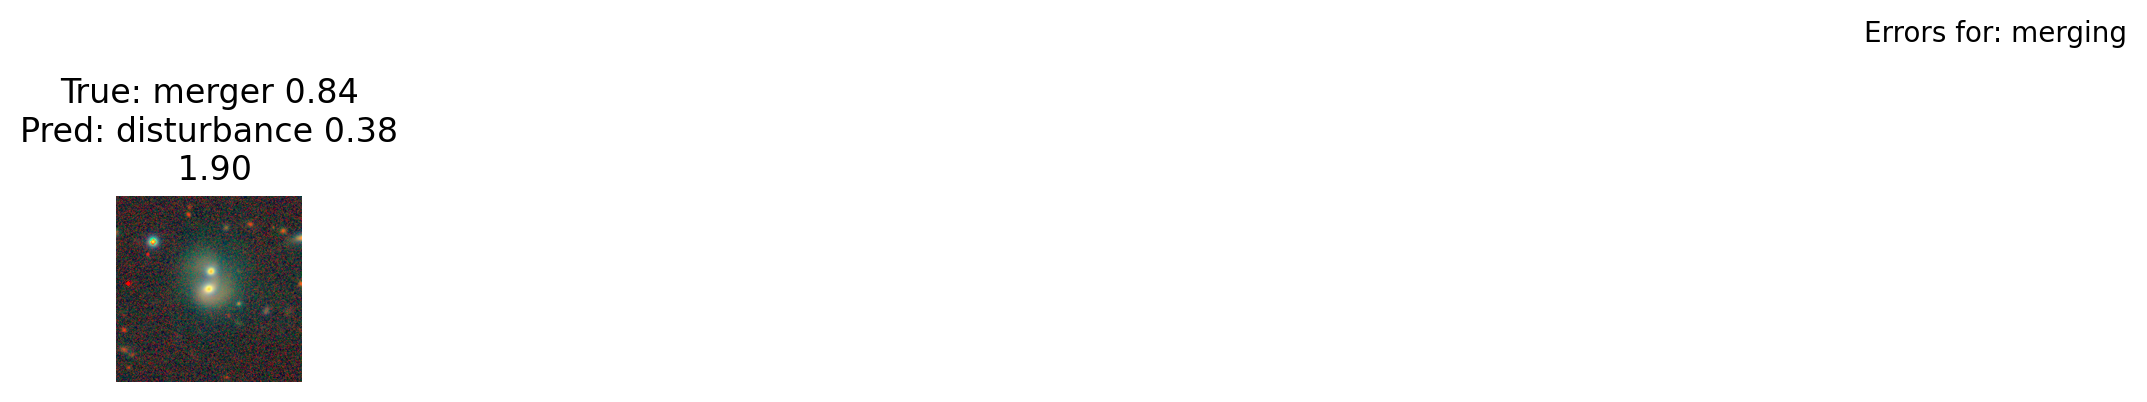

In [32]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=9)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=3)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=4)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=5)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=6)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=7)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=8)

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, keys=9)

In [2]:
def error_df(data, total_votes=20, threshold=0):
    error_detail_dict = {}
    metrics = pd.DataFrame(columns=['Question', 'Method', 'Count', 'Accuracy', 'Precision', 'Recall', 'F1'])
    parent_dir = '/data/public/renhaoye/morphics/error_save/'
    mask_dict = {}
    ans_dict = {}
    for question in schema.questions:
        label_df = pd.DataFrame()
        fraction_df = pd.DataFrame()
        mean_df = pd.DataFrame()
        for answer in question.answers:
            answer_label_col = answer.text + '_label'
            answer_fraction_col = answer.text + '_fraction'
            answer_mean_col = answer.text + '_mean'
            if answer_label_col in data.columns and answer_fraction_col in data.columns and answer_mean_col in data.columns:
                # Adding columns to the respective DataFrames
                label_df[answer.text] = data[answer_label_col]
                fraction_df[answer.text] = data[answer_fraction_col]
                mean_df[answer.text] = data[answer_mean_col]
        votes_sum = label_df.sum(axis=1)
        mask_votes = votes_sum > total_votes
        idx_max = fraction_df[mask_votes].idxmax(axis=1)
        mask_fraction = fraction_df.lookup(idx_max.index, idx_max.values) > threshold
        true_label = idx_max[mask_fraction].apply(lambda x: x.replace('_fraction', ''))
        # true_label = label_df[mask_votes].idxmax(axis=1).apply(lambda x: x.replace('_label', ''))
        pred_label = mean_df.idxmax(axis=1).apply(lambda x: x.replace('_mean', ''))
        pred_label = pred_label[pred_label.index.isin(true_label.index)]
        count1 = len(true_label)
        accuracy1 = accuracy_score(true_label, pred_label)
        precision1 = precision_score(true_label, pred_label, average='weighted')
        recall1 = recall_score(true_label, pred_label, average='weighted')
        f11 = f1_score(true_label, pred_label, average='weighted')
        metrics = metrics.append({'Question': question.text, 'Method': 'Method1', 'Count': count1, 'Accuracy': accuracy1, 'Precision': precision1, 'Recall': recall1, 'F1': f11}, ignore_index=True)
        mask = true_label != pred_label
        error_details = {idx: (true_label[idx], pred_label[idx]) for idx in mask[mask].index}
        error_detail_dict[question.text] = error_details
        mask = mask.reindex(data.index, fill_value=False)
        answer_dir = os.path.join(parent_dir, question.text)
        os.makedirs(answer_dir, exist_ok=True)
        mask_dict[question.text] = mask
    mask_all = pd.concat(mask_dict.values(), axis=1).any(axis=1)
    error_data_all = data[mask_all]
    return mask_dict, error_data_all, error_detail_dict


In [113]:
mask_dict, error_data_all, error_detail_dict = error_df(data, total_votes=20, threshold=0.5)

In [104]:
error_detail_dict.keys()

dict_keys(['smooth_or_featured', 'disk_edge_on', 'has_spiral_arms', 'bar', 'bulge_size', 'how_rounded', 'edge_on_bulge', 'spiral_winding', 'spiral_arm_count', 'merging'])

In [150]:
def display_images_for_each_question(data, error_detail_dict, image_path_column='Image Path', in_decals=False, keys=0):
    key = list(error_detail_dict.keys())
    for question, error_details in error_detail_dict.items():
        if question == key[keys]:
            num_errors = len(error_details)
            num_rows = np.ceil(num_errors / 10).astype(int)
            fig = plt.figure(figsize=(20, 2*num_rows),dpi=200)
            fig.suptitle(f"Errors for: {question}", fontsize=10)
            for idx, (sample_idx, (true_class, pred_class)) in enumerate(error_details.items()):
                img_path = data.loc[sample_idx, image_path_column]
                pred = data.loc[sample_idx, f'{pred_class}_mean']
                frac = data.loc[sample_idx, f'{true_class}_fraction']
                if not os.path.exists(img_path):
                    print(f"Image not found at: {img_path}")
                    continue
                if in_decals:
                    img = arcsinh_rgb(fits.getdata(img_path.replace('out','in')), ["g", "r", "z"])
                else:
                    img = arcsinh_rgb(fits.getdata(img_path), ["g", "r", "z"])
                ax = fig.add_subplot(num_rows, 10, idx+1)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"True: {true_class.split('_')[-1]} {frac:.2f}\nPred: {pred_class.split('_')[-1]} {pred:.2f}")
                print(img_path)
            plt.tight_layout()
            # plt.subplots_adjust(top=0.95)
            plt.show()

In [ ]:
display_images_for_each_question(error_data_all, error_detail_dict, in_decals=True, keys=-2)

In [ ]:
performance(pd.read_csv("/data/public/renhaoye/mgs/predictions_testset_sigmoid_a_54.csv"), total_votes=34, threshold=0.5)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,8426,0.930809,0.930941,0.930809,0.928821
0,disk_edge_on,1054,0.941176,0.987458,0.941176,0.963698
0,has_spiral_arms,812,0.912562,0.955593,0.912562,0.932907
0,bar,651,0.806452,0.889987,0.806452,0.839487
0,bulge_size,659,0.846737,0.888782,0.846737,0.865385
0,how_rounded,1267,0.910024,0.937341,0.910024,0.922879
0,edge_on_bulge,87,0.919540,0.979885,0.919540,0.948082
0,spiral_winding,449,0.795100,0.853543,0.795100,0.818176
0,spiral_arm_count,400,0.832500,0.864433,0.832500,0.843613
0,merging,4233,0.979211,0.978618,0.979211,0.978442


In [ ]:
performance(pd.read_csv("/data/public/renhaoye/mgs/predictions_testset_swin_54.csv"), total_votes=34, threshold=0.5)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,8426,0.917636,0.918812,0.917636,0.914770
0,disk_edge_on,1054,0.913662,0.988479,0.913662,0.949570
0,has_spiral_arms,812,0.895320,0.955689,0.895320,0.923811
0,bar,651,0.804916,0.889706,0.804916,0.842532
0,bulge_size,659,0.846737,0.900637,0.846737,0.871684
0,how_rounded,1267,0.917916,0.937616,0.917916,0.927488
0,edge_on_bulge,87,0.781609,0.959770,0.781609,0.857554
0,spiral_winding,449,0.806236,0.877162,0.806236,0.833699
0,spiral_arm_count,400,0.800000,0.829152,0.800000,0.813480
0,merging,4233,0.980628,0.979643,0.980628,0.979726


In [41]:
performance(pd.read_csv("/data/public/renhaoye/mgs/predictions_testset_sigmoid_a_54.csv"), total_votes=34, threshold=0.8)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,2829,0.993637,0.991190,0.993637,0.992407
0,disk_edge_on,743,0.997308,1.000000,0.997308,0.998652
0,has_spiral_arms,576,0.996528,1.000000,0.996528,0.998261
0,bar,79,1.000000,1.000000,1.000000,1.000000
0,bulge_size,59,1.000000,1.000000,1.000000,1.000000
0,how_rounded,397,0.989924,0.992433,0.989924,0.991160
0,edge_on_bulge,15,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,63,0.984127,1.000000,0.984127,0.991988
0,spiral_arm_count,178,0.983146,0.991011,0.983146,0.986504
0,merging,1957,0.997445,0.998469,0.997445,0.997774


In [42]:
performance(pd.read_csv("/data/public/renhaoye/mgs/predictions_testset_swin_54.csv"), total_votes=34, threshold=0.8)

,Question,Count,Accuracy,Precision,Recall,F1
0,smooth_or_featured,2829,0.990103,0.987751,0.990103,0.988875
0,disk_edge_on,743,0.991925,0.998689,0.991925,0.995281
0,has_spiral_arms,576,0.993056,1.000000,0.993056,0.996516
0,bar,79,0.974684,1.000000,0.974684,0.986875
0,bulge_size,59,1.000000,1.000000,1.000000,1.000000
0,how_rounded,397,0.997481,1.000000,0.997481,0.998737
0,edge_on_bulge,15,1.000000,1.000000,1.000000,1.000000
0,spiral_winding,63,1.000000,1.000000,1.000000,1.000000
0,spiral_arm_count,178,0.955056,0.976522,0.955056,0.965554
0,merging,1957,0.997956,0.998095,0.997956,0.998004
